# Basic experiment section

Previous experiments showed that working with all 1517 is complicated. For the sake of simplicity, here we will choose just 2 relativel balanced classes and solve classification problem for them. 

## Data preparation

Here we just use data preparation module to get sample and target and extract 2 desired classes from them. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
! pip3 install torchinfo
from torchinfo import summary
import torchvision
import torch 
from IPython.display import clear_output
from torch.utils.data import Dataset, random_split
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from collections import defaultdict
import time


In [2]:
import os
import shutil

import glob
import requests

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 5.1MB/s 


In [ ]:
from transformers import AlbertTokenizer, XLNetTokenizer, AutoModel, pipeline
import re
import os
import requests
from tqdm.auto import tqdm

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained("Rostlab/prot_albert", do_lower_case=False )
#tokenizer = XLNetTokenizer.from_pretrained("Rostlab/prot_xlnet", do_lower_case=False)



In [ ]:
model = AutoModel.from_pretrained("Rostlab/prot_albert")
#model = AutoModel.from_pretrained("Rostlab/prot_xlnet")

In [ ]:
fe = pipeline('feature-extraction', model=model, tokenizer=tokenizer,device=0)

In [ ]:
seq_data = pd.read_csv("/content/drive/MyDrive/m1p/seq_to_fold.csv")
seq_data = seq_data[["FOLD", "sequence"]]
seq_data.head()

,FOLD,sequence
0,1400,DMKRQQRFFRIPFIRPADQYKDPQNKKKGWWYAHFDGPWIARQMEL...
1,1400,RQREIEMNRQQRFFRIPFIRPADQYKDPQSKKKGWWYAHFDGPWIA...
2,11,MKIKVALLDKDKEYLDRLTGVFNTKYADKLEVYSFTDEKNAIESVK...
3,11,QTPHILIVEDELVTRNTLKSIFEAEGYDVFEATDGAEMHQILSEYD...
4,11,SFERVFGKRVIILGGGALVSQVAIGAISEADRHNLRGERISVDTMP...


## Choosing two balanced classes.

This section is devoted to narrowing the dataset to just two classes. 

In [ ]:
def print_fold_info(fold_id, data):
  """
  Plots distribution of sequence lengths in fold as well as number of sequences.
  """
  fold_data = data[data['FOLD'] == fold_id]
  sequences = fold_data.loc[:, "sequence"]
  lengths = sequences.apply(lambda x:  len(x))
  plt.figure(figsize = (9, 6))
  plt.hist(lengths, bins = 15, density=False, facecolor='purple', alpha=0.55)
  plt.xlabel('Length')
  plt.ylabel('Number of elements')
  plt.title(f'Histogram of sequence lengths for fold {fold_id}')
  plt.grid(True)
  plt.show()
  print(f"Number of elements in fold = {len(sequences)}")

def compare_folds(fold_id, fold_other, data):
  """
  Plots distribution of sequence lengths in fold as well as number of sequences
  for two given folds.
  """
  fold_data1 = data[data['FOLD'] == fold_id]
  sequences1 = fold_data1.loc[:, "sequence"]
  lengths1 = sequences1.apply(lambda x:  len(x))
  fold_data2 = data[data['FOLD'] == fold_other]
  sequences2 = fold_data2.loc[:, "sequence"]
  lengths2 = sequences2.apply(lambda x:  len(x))
  plt.figure(figsize = (9, 6))
  plt.hist(lengths1, bins = 15, density=True, facecolor='purple', alpha=0.5, 
           label = f"fold_id = {fold_id}")
  plt.hist(lengths2, bins = 15, density=True, facecolor='green', alpha=0.5, 
           label = f"fold_id = {fold_other}")
  plt.xlabel('Length')
  plt.ylabel('Density')
  plt.title(f'Comparison of two given folds')
  plt.grid(True)
  plt.legend()
  plt.show()
  print(f"Number of elements in fold {fold_id} = {len(sequences1)}, in" 
  f" fold {fold_other} = {len(sequences2)}")


First, we fix relatively balanced fold (finding it manually). 

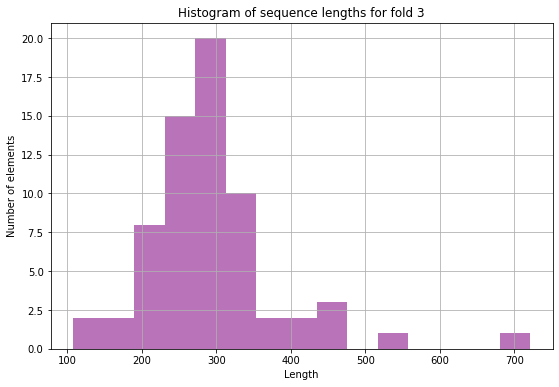

Number of elements in fold = 66


In [ ]:
print_fold_info(3, seq_data)

After finding that fold 3 is relatively balanced, we shall find a pair for it. 

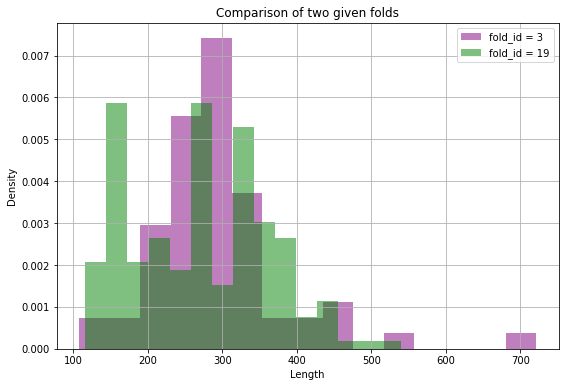

Number of elements in fold 3 = 66, in fold 19 = 187


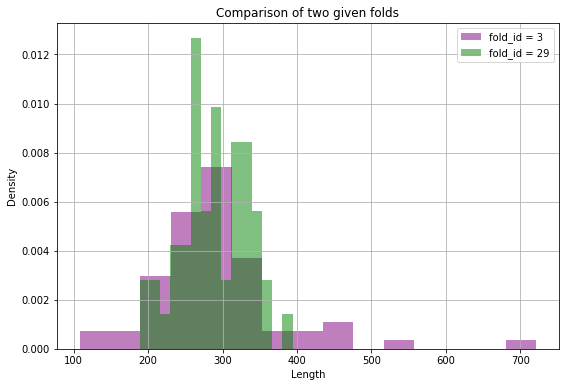

Number of elements in fold 3 = 66, in fold 29 = 52


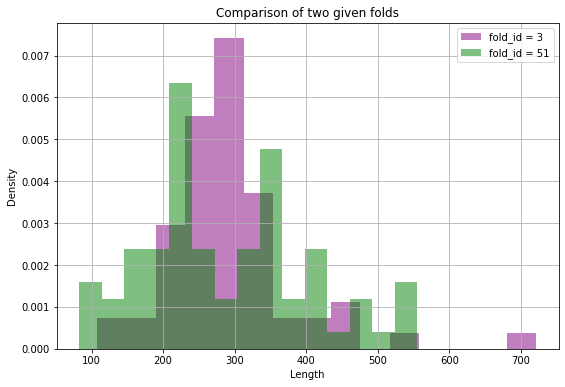

Number of elements in fold 3 = 66, in fold 51 = 80


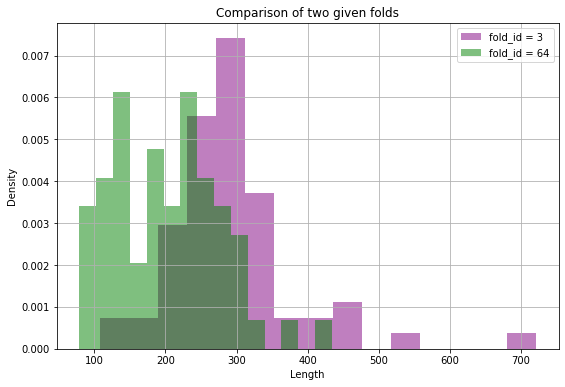

Number of elements in fold 3 = 66, in fold 64 = 62


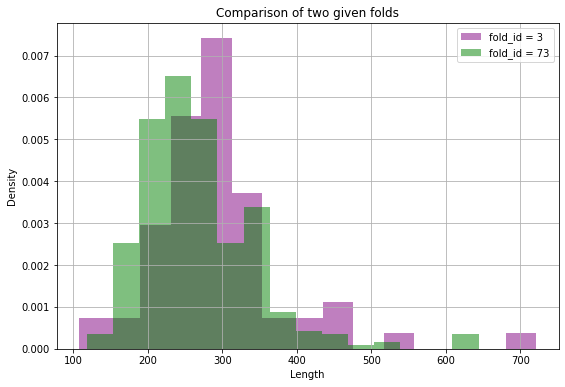

Number of elements in fold 3 = 66, in fold 73 = 328


In [ ]:
for i in (19, 29, 51, 64, 73):
  compare_folds(3, i, seq_data)

**Conclusion:** classes 3 and 51 have quite similar distribution of lengths and the number of sequences in each fold is close (66 and 80). We've decided to choose these two classes. 

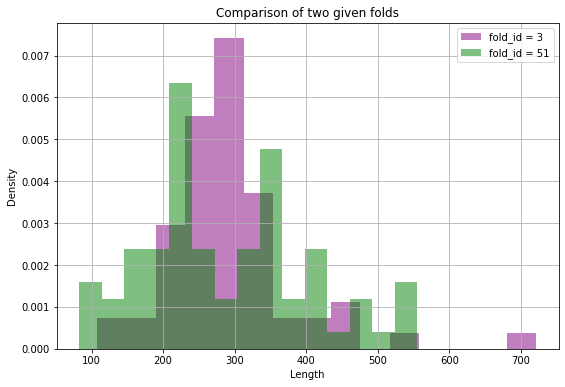

Number of elements in fold 3 = 66, in fold 51 = 80


In [ ]:
compare_folds(3, 51, seq_data)

In [4]:
def scop_seq_to_bert_seq(scop_seq):
    """
    Converts sequences from scop format to prot bert format
    """
    def expand(sequence):
        """
        Expands one sequnce
        """
        return " ".join(sequence.rstrip())
    
    return scop_seq.apply(expand)

In [5]:
seq_data = pd.read_csv("/content/drive/MyDrive/m1p/seq_to_fold.csv")
seq_data = seq_data[["FOLD", "sequence"]]
seq_data.head()
binary_data = seq_data[(seq_data['FOLD'] == 3) |  (seq_data['FOLD'] == 51)]

In [6]:
binary_data

,FOLD,sequence
779,51,KPKEEIKIVEPNGAEKTKLNLNFGVGKLNISGNEEKLMKGKFIYSE...
780,51,DHVKGDGKLTSKKISVADYNEIKVDGVIDFNYEQSDDPSTVEVTVD...
781,51,GDGNITTENIPVSEYDCLELEGGGMVVNYTQSDAPEGLEIKTDRNI...
782,51,ADHVKGNGKLSTKKITIDDFNAIKFDGVIDFNYEQSESTPHIEITV...
783,51,DKRIDGNGNPETREIKISDYDEITFVGSADFEYEQSDKAPYLSVTI...
...,...,...
29672,51,MNVGEILRHYAAGKRNFQHINLQEIELTNASLTGADLSYADLRQTR...
29867,51,AAYDNQTIGRGETSKSMHLSAGDTAKNTTINSGGKQYVSSGGSATS...
29868,51,ADIVVHPGETVNGGTLVNHDNQFVSGTANGVTVSTGLELGPDSDEN...
30695,3,QKDLADYPVKLKAYEDEQTSIKAALAELEKHKNEDGNLTEPSAQNL...


Now we will drop sequences with length >= 450 and < 100, reducing the size of BERT features later. 

In [7]:
sequences = binary_data.loc[:, "sequence"]
lengths = sequences.apply(lambda x:  len(x))

In [8]:
lengths.describe()

count    146.000000
mean     291.767123
std      104.093595
min       83.000000
25%      222.500000
50%      275.000000
75%      342.250000
max      721.000000
Name: sequence, dtype: float64

In [9]:
mask = ((lengths >= 100) & (lengths <= 450)).to_numpy()
mask.sum()

134

In [10]:
preprocessed_data = binary_data[mask]

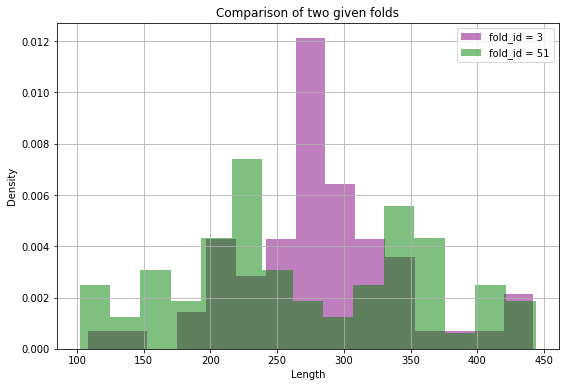

Number of elements in fold 3 = 63, in fold 51 = 71


In [ ]:
compare_folds(3, 51, preprocessed_data)

## Applying BERT to the reduced dataset.

In [11]:
sequences = preprocessed_data['sequence']
sequences = scop_seq_to_bert_seq(sequences).to_numpy()
target = preprocessed_data['FOLD'].to_numpy()
target = (target == 3).astype(int)

In [ ]:
sequences[:5]

array(['K P K E E I K I V E P N G A E K T K L N L N F G V G K L N I S G N E E K L M K G K F I Y S E N E W K P E I K Y E V K D K D G E L E I S Q P G L K S G N V S L N N K R N E W N I N L N E K I P T E I K L S L G T G E F K A D L S K I N L K E L N V G M G V G K V D L D I S G N Y K N N V K V N I E G G V G E A T V Y L P K S I G V K I K A E K G V G A V N A N G F I V E G E N I Y K N S Q Y G K S K N S I E V N I E A G V G A I N I K Q K',
       'D H V K G D G K L T S K K I S V A D Y N E I K V D G V I D F N Y E Q S D D P S T V E V T V D Q N L H P Y V N I E V K D R V L T I A F K G A K V D H F T K F I V K T N S K W L A A A K V S G N A N F M V N S P L T G D E T V I K A N A N S L V Q L K E T V T V G K L D L N V S G S A N M V V N H L E A D K I E C D I D G S G S I T I K K G N A K E G D Y S I V S S G D I H A F G L A V P Q L S C K V T G N G L A E V H A T D N L K A N V V G K G N I R Y K G P T A V Q Q R I I G K G T V E E V',
       'G D G N I T T E N I P V S E Y D C L E L E G G G M V V N Y T Q S D A P E 

In [ ]:
# !mkdir /content/drive/MyDrive/m1p/two_classes_albert/

In [ ]:
for i in tqdm(range(len(sequences))):
  torch.save(torch.tensor(fe(sequences[i])), "/content/drive/MyDrive/m1p/two_classes_albert/" + str(i) + ".torch")


**Using CNN**:

This section is devoted to applying CNN to the two-class data.

In [12]:
class K_max_pooling_1d(nn.Module):
    def __init__(self, k):
        super(K_max_pooling_1d, self).__init__()
        self.k = k

    def forward(self, x):
        #if x.shape[2] < self.k:
        #  return F.pad(input=x, pad=(0, self.k - x.shape[2], 0, 0), 
        #                 mode='constant', value=0)
        top = torch.topk(x, k = self.k)
        return top.values

In [13]:
 def plot_learning_curves(history):
    '''

    :param history: (dict)
        accuracy and loss for traning and validation
    '''
    # sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('lostt', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Accuracy', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('loss', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

In [14]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    label,
    num_epochs=50
):

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            
            #X_batch = torch.transpose(torch.tensor(fe(train_X[i])), 1, 2).to(device)
            #y_batch = torch.tensor(train_Y[i]).unsqueeze(0).to(device)
                        
            X_batch = torch.transpose(X_batch.squeeze(0), 1, 2).to(device)
            y_batch = y_batch.to(device)

            # Логиты на выходе модели
            logits = model(X_batch)

            # Подсчитываем лосс
            loss = criterion(logits, y_batch.long().to(device))

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()
            
            # Сохраяняем лоссы и точность на трейне
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = torch.transpose(X_batch.squeeze(0), 1, 2).to(device)
            y_batch = y_batch.to(device)
            
            #X_batch = torch.transpose(torch.tensor(fe(val_X[i])), 1, 2).to(device)
            #y_batch = torch.tensor(val_Y[i]).unsqueeze(0).to(device)
            
            # Логиты, полученные моделью
            logits = model(X_batch)
            # Лосс на валидации
            loss = criterion(logits, y_batch.long().to(device))

            # Сохраяняем лоссы и точность на валидации
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        if epoch % 5 == 1:
            torch.save(model.state_dict(), 
                   "/content/drive/MyDrive/m1p/two_classes_albert/states/model_state_" + label + "_" + str(epoch))
    return model, history

In [ ]:
# !mkdir /content/drive/MyDrive/m1p/two_classes_albert/states/

### MODEL 1

In [ ]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv1d(in_channels=4096, out_channels=256, 
                                    kernel_size=7, stride=1, padding=3))
model.add_module('relu1', nn.ReLU())
#model.add_module("pool1", nn.MaxPool1d(2))

for i in range(2, 4):
  
  model.add_module('conv' + str(i), nn.Conv1d(in_channels=256, out_channels=256, 
                                    kernel_size=7, stride=1, padding=3))
  model.add_module('relu' + str(i), nn.ReLU())
model.add_module('conv4', nn.Conv1d(in_channels=256, out_channels=128, 
                                  kernel_size=7, stride=1, padding=3))
model.add_module('relu4', nn.ReLU())
for i in range(5, 7):
  
  model.add_module('conv' + str(i), nn.Conv1d(in_channels=128, out_channels=128, 
                                    kernel_size=7, stride=1, padding=3))
  model.add_module('relu' + str(i), nn.ReLU())
model.add_module('conv7', nn.Conv1d(in_channels=128, out_channels=64, 
                                  kernel_size=7, stride=1, padding=3))
model.add_module('relu7', nn.ReLU())
for i in range(8, 10):
  
  model.add_module('conv' + str(i), nn.Conv1d(in_channels=64, out_channels=64, 
                                    kernel_size=7, stride=1, padding=3))
  model.add_module('relu' + str(i), nn.ReLU())
model.add_module('conv10', nn.Conv1d(in_channels=64, out_channels=32, 
                                  kernel_size=7, stride=1, padding=3))
model.add_module('relu10', nn.ReLU())
# model.add_module('conv11', nn.Conv1d(in_channels=32, out_channels=16, 
#                                   kernel_size=7, stride=1, padding=3))
# model.add_module('relu11', nn.ReLU())
model.add_module('K_max_pooling', K_max_pooling_1d(30))
model.add_module('flatteing', nn.Flatten())
model.add_module('FC-layer', nn.Linear(960, 2))


summary(model, (32, 4096, 300))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [32, 256, 300]            7,340,288
├─ReLU: 1-2                              [32, 256, 300]            --
├─Conv1d: 1-3                            [32, 256, 300]            459,008
├─ReLU: 1-4                              [32, 256, 300]            --
├─Conv1d: 1-5                            [32, 256, 300]            459,008
├─ReLU: 1-6                              [32, 256, 300]            --
├─Conv1d: 1-7                            [32, 128, 300]            229,504
├─ReLU: 1-8                              [32, 128, 300]            --
├─Conv1d: 1-9                            [32, 128, 300]            114,816
├─ReLU: 1-10                             [32, 128, 300]            --
├─Conv1d: 1-11                           [32, 128, 300]            114,816
├─ReLU: 1-12                             [32, 128, 300]            --
├─Conv1d: 1-13                           [32, 64, 300

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [23]:
class FoldDataset(Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, length, labels):
        'Initialization'
        super(Dataset, self).__init__()
        self.length = length
        self.labels = labels
  def __len__(self):
        'Denotes the total number of samples'
        return self.length

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample

        # Load data and get label
        data = torch.load("/content/drive/MyDrive/m1p/two_classes_albert/" + str(index) + ".torch")
        
        return data, self.labels[index]

In [24]:
def collate_fn(batch):
  """
  batch: list of individual elements
  """
  max_sz = 0
  for elem in batch:
    max_sz = max(max_sz, elem[0].shape[1])
  target = torch.tensor([elem[1] for elem in batch])
  return torch.cat([F.pad(input=elem[0], pad=(0, 0, 0, max_sz - elem[0].shape[1]), 
                          mode='constant', value=0) for elem in batch]), target

In [25]:
target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1])

In [26]:
dataset = FoldDataset(len(target), target)
#first_generator = torch.Generator().manual_seed(17)
#dataset, other = random_split(
#    dataset, lengths=(500, 34592 - 500), generator=first_generator)

In [27]:
val_ratio = 0.35
test_ratio = 0
data_len = len(dataset)
test_len = int(data_len * test_ratio)
val_len = int(data_len * val_ratio)
train_len = data_len - val_len - test_len
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(
    dataset, lengths=(train_len, val_len, test_len), generator=generator)
len(train_dataset), len(val_dataset), len(test_dataset)

(88, 46, 0)

In [29]:
batch_size = 16

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
device

'cuda'

Epoch 100 of 100 took 2.996s
  training loss (in-iteration): 	0.673608
  validation loss (in-iteration): 	0.724689
  training accuracy: 			58.33 %
  validation accuracy: 			43.15 %


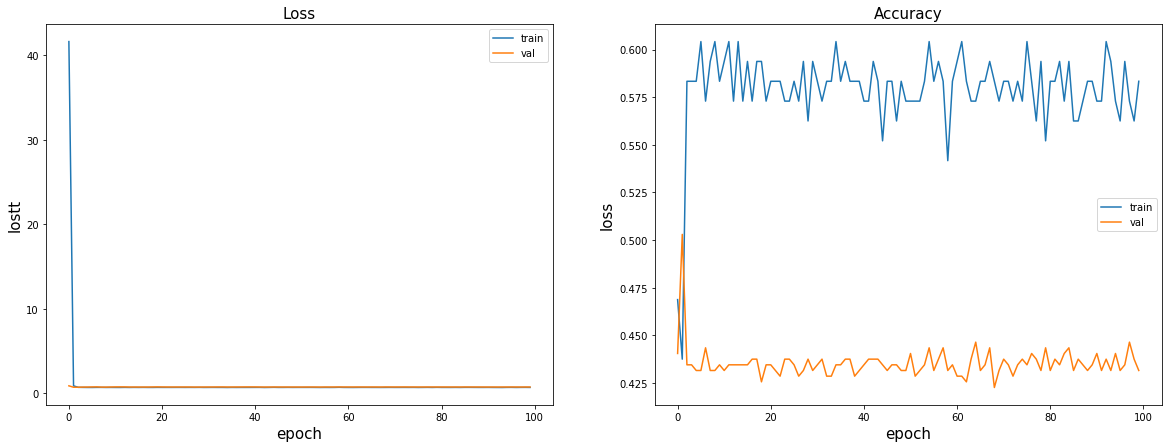

In [ ]:
model, history = train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen,
    "second_exp", num_epochs=100)

**Conclusion:** well, first designed architercture seem to be awful. Reaching <50% accuracy with only 2 classes is an incredibly bad result. Moreover, for some reasons the NN didn't overtrain despite the fact that there were only around 130 objects in the sample and 8m parameters. 

### Model 2

The idea here is that we usel dilation to increase the field of perception.

In [ ]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv1d(in_channels=4096, out_channels=256, 
                                    kernel_size=7, stride=1, padding=3,
                                    dilation = 2))
model.add_module('relu1', nn.ReLU())

for i in range(2, 4):
  
  model.add_module('conv' + str(i), nn.Conv1d(in_channels=256, out_channels=256, 
                                    kernel_size=7, stride=1, padding=3,
                                    dilation = 2))
  model.add_module('relu' + str(i), nn.ReLU())
model.add_module('conv4', nn.Conv1d(in_channels=256, out_channels=128, 
                                  kernel_size=7, stride=1, padding=3,
                                    dilation = 2))
model.add_module('relu4', nn.ReLU())
for i in range(5, 7):
  
  model.add_module('conv' + str(i), nn.Conv1d(in_channels=128, out_channels=128, 
                                    kernel_size=7, stride=1, padding=3,
                                    dilation = 2))
  model.add_module('relu' + str(i), nn.ReLU())
model.add_module('conv7', nn.Conv1d(in_channels=128, out_channels=64, 
                                  kernel_size=7, stride=1, padding=3,
                                    dilation = 2))
model.add_module('relu7', nn.ReLU())
for i in range(8, 10):
  
  model.add_module('conv' + str(i), nn.Conv1d(in_channels=64, out_channels=64, 
                                    kernel_size=7, stride=1, padding=3,
                                    dilation = 2))
  model.add_module('relu' + str(i), nn.ReLU())
model.add_module('conv10', nn.Conv1d(in_channels=64, out_channels=32, 
                                  kernel_size=7, stride=1, padding=3,
                                    dilation = 2))
model.add_module('relu10', nn.ReLU())
model.add_module('K_max_pooling', K_max_pooling_1d(30))
model.add_module('flatteing', nn.Flatten())
model.add_module('FC-layer', nn.Linear(960, 2))


summary(model, (32, 4096, 300))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [32, 256, 294]            7,340,288
├─ReLU: 1-2                              [32, 256, 294]            --
├─Conv1d: 1-3                            [32, 256, 288]            459,008
├─ReLU: 1-4                              [32, 256, 288]            --
├─Conv1d: 1-5                            [32, 256, 282]            459,008
├─ReLU: 1-6                              [32, 256, 282]            --
├─Conv1d: 1-7                            [32, 128, 276]            229,504
├─ReLU: 1-8                              [32, 128, 276]            --
├─Conv1d: 1-9                            [32, 128, 270]            114,816
├─ReLU: 1-10                             [32, 128, 270]            --
├─Conv1d: 1-11                           [32, 128, 264]            114,816
├─ReLU: 1-12                             [32, 128, 264]            --
├─Conv1d: 1-13                           [32, 64, 258

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Epoch 50 of 50 took 3.997s
  training loss (in-iteration): 	0.675217
  validation loss (in-iteration): 	0.719856
  training accuracy: 			60.42 %
  validation accuracy: 			44.05 %


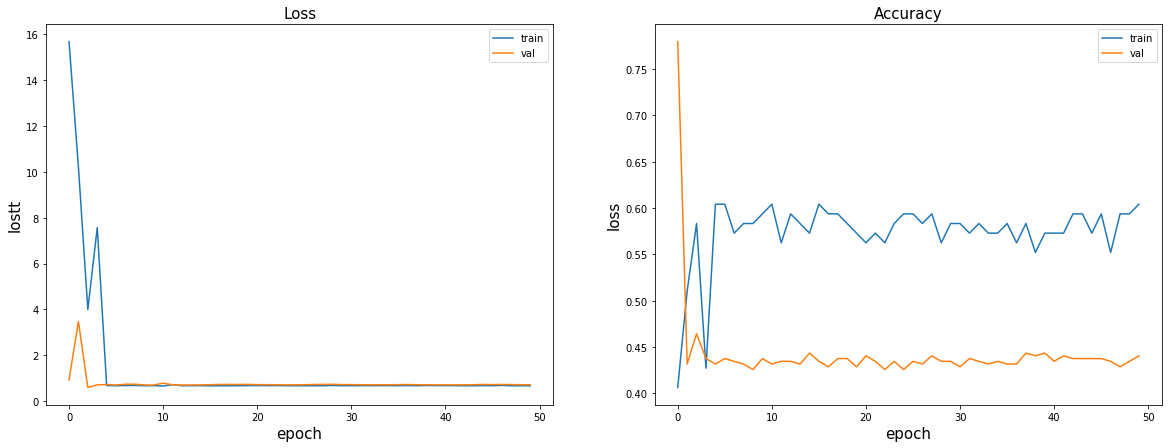

In [ ]:
model, history = train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen,
    "second_exp", num_epochs=50)

### Model 3

In [ ]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv1d(in_channels=4096, out_channels=256, 
                                    kernel_size=7, stride=1, padding=3,
                                    dilation = 5))
model.add_module('relu1', nn.ReLU())

for i in range(2, 4):
  
  model.add_module('conv' + str(i), nn.Conv1d(in_channels=256, out_channels=256, 
                                    kernel_size=7, stride=1, padding=3,
                                    dilation = 5))
  model.add_module('relu' + str(i), nn.ReLU())
model.add_module('conv4', nn.Conv1d(in_channels=256, out_channels=128, 
                                  kernel_size=7, stride=1, padding=3,
                                    dilation = 5))
model.add_module('relu4', nn.ReLU())
for i in range(5, 7):
  
  model.add_module('conv' + str(i), nn.Conv1d(in_channels=128, out_channels=128, 
                                    kernel_size=7, stride=1, padding=3,
                                    dilation = 5))
  model.add_module('relu' + str(i), nn.ReLU())
model.add_module('conv7', nn.Conv1d(in_channels=128, out_channels=64, 
                                  kernel_size=7, stride=1, padding=3,
                                    dilation = 5))
model.add_module('relu7', nn.ReLU())
for i in range(8, 10):
  
  model.add_module('conv' + str(i), nn.Conv1d(in_channels=64, out_channels=64, 
                                    kernel_size=7, stride=1, padding=3,
                                    dilation = 5))
  model.add_module('relu' + str(i), nn.ReLU())
model.add_module('conv10', nn.Conv1d(in_channels=64, out_channels=32, 
                                  kernel_size=7, stride=1, padding=3,
                                    dilation = 5))
model.add_module('relu10', nn.ReLU())
model.add_module('K_max_pooling', K_max_pooling_1d(30))
model.add_module('flatteing', nn.Flatten())
model.add_module('FC-layer', nn.Linear(960, 2))


summary(model, (32, 4096, 300))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [32, 256, 276]            7,340,288
├─ReLU: 1-2                              [32, 256, 276]            --
├─Conv1d: 1-3                            [32, 256, 252]            459,008
├─ReLU: 1-4                              [32, 256, 252]            --
├─Conv1d: 1-5                            [32, 256, 228]            459,008
├─ReLU: 1-6                              [32, 256, 228]            --
├─Conv1d: 1-7                            [32, 128, 204]            229,504
├─ReLU: 1-8                              [32, 128, 204]            --
├─Conv1d: 1-9                            [32, 128, 180]            114,816
├─ReLU: 1-10                             [32, 128, 180]            --
├─Conv1d: 1-11                           [32, 128, 156]            114,816
├─ReLU: 1-12                             [32, 128, 156]            --
├─Conv1d: 1-13                           [32, 64, 132

Epoch 50 of 50 took 3.936s
  training loss (in-iteration): 	0.686103
  validation loss (in-iteration): 	0.731796
  training accuracy: 			56.25 %
  validation accuracy: 			42.26 %


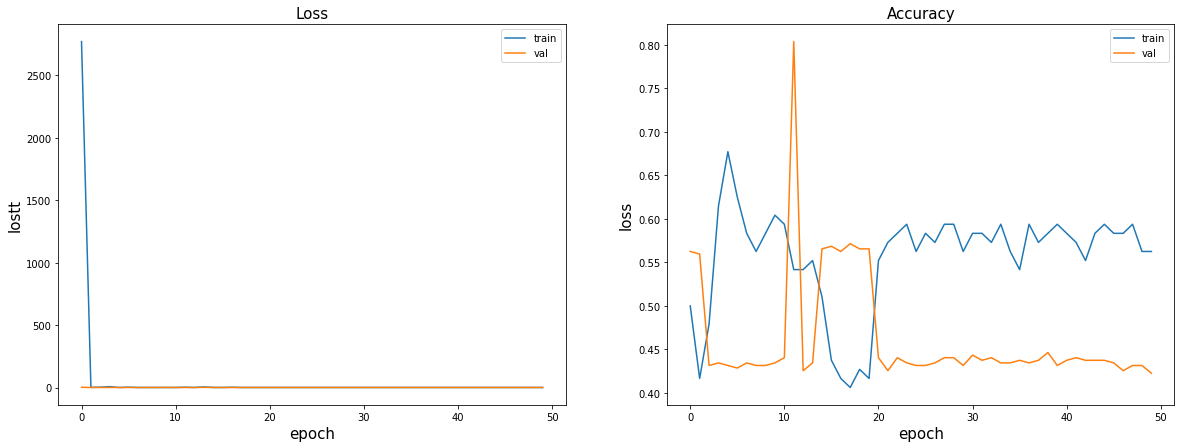

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen,
    "second_exp", num_epochs=50)

### Model 4


In [21]:
model = nn.Sequential()
model.add_module('K_max_pooling', K_max_pooling_1d(30))
# model.add_module('conv1', nn.Conv1d(in_channels=4096, out_channels=256, 
#                                     kernel_size=7, stride=1, padding=3))
model.add_module('relu1', nn.ReLU())
model.add_module('flatteing', nn.Flatten())
model.add_module('FC-layer', nn.Linear(122880, 2))


summary(model, (32, 4096, 300))

Layer (type:depth-idx)                   Output Shape              Param #
├─K_max_pooling_1d: 1-1                  [32, 4096, 30]            --
├─ReLU: 1-2                              [32, 4096, 30]            --
├─Flatten: 1-3                           [32, 122880]              --
├─Linear: 1-4                            [32, 2]                   245,762
Total params: 245,762
Trainable params: 245,762
Non-trainable params: 0
Total mult-adds (M): 7.86
Input size (MB): 157.29
Forward/backward pass size (MB): 0.00
Params size (MB): 0.98
Estimated Total Size (MB): 158.27

Epoch 50 of 50 took 2.601s
  training loss (in-iteration): 	0.000000
  validation loss (in-iteration): 	0.886699
  training accuracy: 			100.00 %
  validation accuracy: 			93.45 %


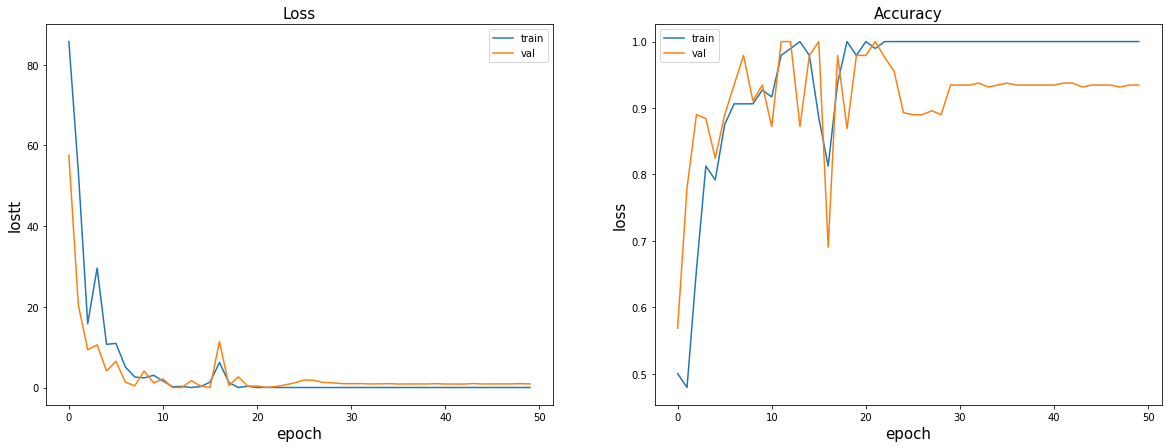

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen,
    "second_exp", num_epochs=50)

**Conclusion:** after several attemnts we've reduced the model to the mininal architecture of two layers and finally the NN trained successfully (apparently overtrained in the process, however)